## Time Series Forecasting using LSTM - TimeSeriesGenerator

In [147]:
#Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math


from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [209]:
raw = pd.read_csv('SalesData.csv')
raw['Date'] = pd.to_datetime(raw['Date'])
raw.sort_values('Date', inplace=True, ignore_index=True)
raw['Profit'] = round(((raw['Profit']/1000000000)*-1),2)
table = raw[9:266] #There are zeros in the initial observations. The final observation is for 2022-03-01.
table.tail()

,Date,Sales,Profit
261,2021-01-10,1219826,19.28
262,2021-01-11,1231628,19.15
263,2021-01-12,1299828,19.31
264,2022-01-01,1197906,19.87
265,2022-01-02,1263722,19.77


In [145]:
pd.set_option('display.max_rows', None)

In [165]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 9 to 265
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    257 non-null    datetime64[ns]
 1   Sales   257 non-null    int64         
 2   Profit  257 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 6.2 KB


In [166]:
# we will do a univariate time series analysis first
df = table['Profit']
df = np.array(df)
df = df.reshape(-1, 1)

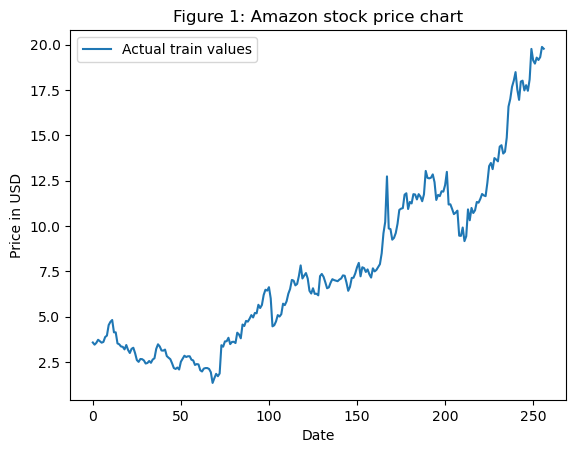

In [210]:
#Plot df
plt.plot(df, label="Actual train values")
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Figure 1: Amazon stock price chart')
plt.legend()
plt.show()

In [168]:
# we'll use 200 records for training and 57 records for testing
train=df[:200]
test = df[200:]
train.shape, test.shape

((200, 1), (57, 1))

In [169]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
strain = scaler.fit_transform(train)
stest= scaler.transform(test)

In [170]:
#check dimensions of the array
strain.ndim

2

In [171]:
train = np.reshape(train, (train.shape[0], 1))
test = np.reshape(test, (test.shape[0], 1))

### Use TimeSeriesGenerator to generate data in sequences.

In [172]:
#Import time series generator 
from keras.preprocessing.sequence import TimeseriesGenerator

In [173]:
seq_size = 5  # number of steps to lookback
n_features = 1 # number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(strain, strain, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(strain))
print("Total number of samples in the generated data with seq_size 5 = ", len(train_generator))

Total number of samples in the original training data =  200
Total number of samples in the generated data with seq_size 5 =  195


In [174]:
train_generator[0]

(array([[[0.19076133],
         [0.18049615],
         [0.18905047],
         [0.20359281],
         [0.19674936]]]),
 array([[0.1899059]]))

In [175]:
train_generator[10]

(array([[[0.28828058],
         [0.2968349 ],
         [0.23866553],
         [0.23866553],
         [0.18648417]]]),
 array([[0.18220701]]))

In [176]:
x,y = train_generator[10]

In [177]:
step_size = 5  # number of steps to lookback
n_features = 1 # number of features. This dataset is univariate so it is 1
test_generator = TimeseriesGenerator(stest, stest, length = seq_size, batch_size=1)
print("Total number of samples in the original testing data = ", len(stest))
print("Total number of samples in the generated test data with seq_size 5 = ", len(test_generator))

Total number of samples in the original testing data =  57
Total number of samples in the generated test data with seq_size 5 =  52


In [178]:
x,y = test_generator[200]

In [179]:
train_generator[0], test_generator[0]

((array([[[0.19076133],
          [0.18049615],
          [0.18905047],
          [0.20359281],
          [0.19674936]]]),
  array([[0.1899059]])),
 (array([[[0.9332763 ],
          [0.99572284],
          [0.84174508],
          [0.84260051],
          [0.82035928]]]),
  array([[0.79640719]])))

In [180]:
#Define Model 

#instantiate and fit the model. You can use stacked LSTM's. 
# if you add another layer, use return_sequence=TRUE in the first layer, so that the sequence is returned to layer 2.

#model.reset_states() #this is only if you run the model again
model = Sequential()
model.add(LSTM(15, input_shape=(5, 1), activation='relu')) # 3 is the timesteps, 1 is the no. of features
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
print(model.summary())

# fit the model
#del history #this is only if you run the model again
#set verbose=False if you don't want to see the output
history = model.fit(train_generator, validation_data=test_generator, batch_size = 32, epochs = 100, verbose = 0)


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 15)                1020      
                                                                 
 dropout_22 (Dropout)        (None, 15)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 16        
                                                                 
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
None


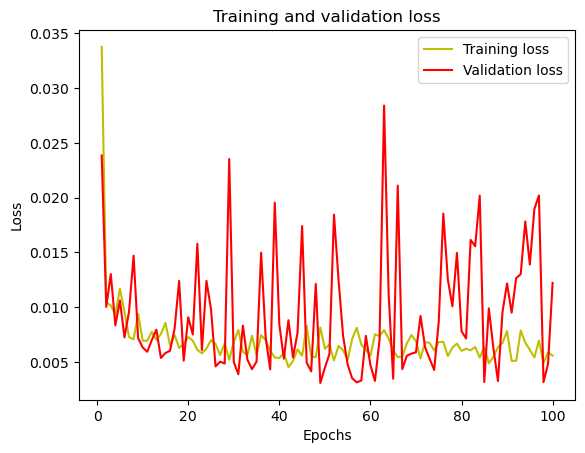

In [181]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Alternatively, try to use a **Learning rate scheduler**, which can automatically adjust the learning rate during training. This can help the model converge faster and produce better results. 

In [182]:
# import the LearningRateScheduler class
from tensorflow.keras.callbacks import LearningRateScheduler

A few ways you can fix fluctuating loss.
<br/><br/>
If your training loss in an LSTM (long short-term memory) sequential model is fluctuating up and down, it could be caused by a few different factors.
<br/><br/>
**1. High Learning Rate:** One possible explanation is that you are using a large learning rate in your model, which can cause the model's weights to oscillate and lead to unstable training. In this case, you may want to try reducing the learning rate to see if that helps stabilize the training process. This is done below by using a learning rate of 0.0001
<br/><br/>
**2. Overfitting:** Another possible explanation is that your model is overfitting to the training data. Overfitting occurs when a model learns the details of the training data too well, and as a result, it performs poorly on unseen data. If this is the case, you may want to try using regularization techniques, such as dropout or weight decay, to prevent the model from overfitting. This is done below with dropout 0.2 <br/>
When a dropout layer is included in an LSTM model, it randomly drops out a certain proportion of the units in the LSTM layer during training. However, using a dropout layer can also make the model more difficult to train, as it reduces the capacity of the LSTM layer.
<br/><br/>
**3. Less epochs:** Finally, it's also possible that your model simply hasn't converged yet, and the training loss is still fluctuating because the model is still making adjustments to its weights. In this case, you may need to train the model for longer to allow it to converge. Add more epochs.
<br/>

**4. Too many LSTM units:** The number of units in an LSTM (long short-term memory) layer can have a significant impact on the performance of the model. In general, increasing the number of units in the LSTM layer can improve the model's ability to learn complex patterns in the data, but it can also make the model more computationally expensive and harder to train.

In [183]:
#Define Model # import the Adam optimizer
from tensorflow.keras.optimizers import Adam

#instantiate and fit the model. You can use stacked LSTM's. 
# if you add another layer, use return_sequence=TRUE in the first layer, so that the sequence is returned to layer 2.

model1 = Sequential()
model1.add(LSTM(3, input_shape=(5, 1), activation='relu')) # 3 is the timesteps, 1 is the no. of features
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(optimizer=Adam(learning_rate=0.0001), loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
print(model1.summary())

# fit the model
#del history #this is to clear the variable
#set verbose=False if you don't want to see the output
history = model1.fit(train_generator, validation_data=test_generator, batch_size = 20, epochs = 100, verbose = 0)


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 3)                 60        
                                                                 
 dropout_23 (Dropout)        (None, 3)                 0         
                                                                 
 dense_23 (Dense)            (None, 1)                 4         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
None


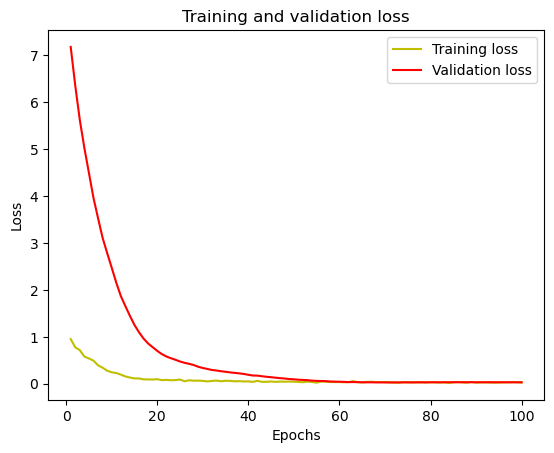

In [184]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [185]:
#Make pedictions
trainPredict = model1.predict(train_generator)
testPredict = model1.predict(test_generator)

52/52 [==============================] - 0s 3ms/step


In [186]:
#inverse transform the predictions
trainpredict = scaler.inverse_transform(trainPredict)
testpredict = scaler.inverse_transform(testPredict)

In [187]:
train.ndim, trainPredict.ndim, train.shape, trainPredict.shape

(2, 2, (200, 1), (195, 1))

In [188]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train[5:,0], trainpredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(test[5:], testpredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.29 RMSE
Test Score: 2.02 RMSE


In [189]:
train.shape

(200, 1)

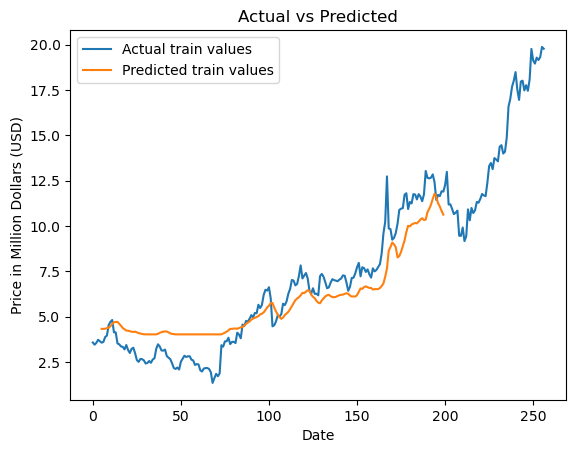

In [194]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[5:len(trainpredict)+5] = trainpredict

plt.plot(df, label="Actual train values")
plt.plot(trainPredictPlot, label='Predicted train values')

plt.xlabel('Date')
plt.ylabel('Price in Million Dollars (USD)')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


In [191]:
trainpredict.shape, testpredict.shape, len(df)

((195, 1), (52, 1), 257)

In [200]:

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainpredict)+10:] = testpredict

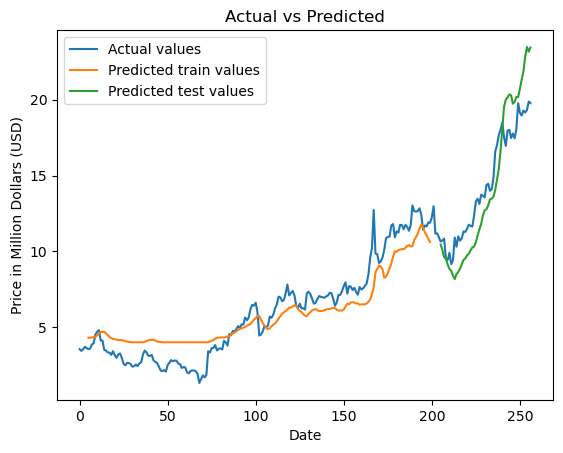

In [201]:
# plot baseline and predictions
plt.plot(df, label="Actual values")
plt.plot(trainPredictPlot, label ="Predicted train values")
plt.plot(testPredictPlot, label='Predicted test values')

plt.xlabel('Date')
plt.ylabel('Price in Million Dollars (USD)')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

## The validation loss is high, tune the model to improve the validation loss.

## Let's Forecast

In [220]:
x,y = test_generator[51]
x, x.shape

(array([[[1.50641574],
         [1.534645  ],
         [1.52352438],
         [1.53721129],
         [1.58511548]]]),
 (1, 5, 1))

In [221]:
# how to make a single prediction
last_test_batch = x #Final data points in test 

#Check how close we are with the acutal first value in the test set and the one predicted by LSTM using the final row in the train set
m = model1.predict(x)
m

1/1 [==============================] - 0s 31ms/step


array([[1.8893925]], dtype=float32)

In [222]:
raw.tail()

,Date,Sales,Profit
262,2021-01-11,1231628,19.15
263,2021-01-12,1299828,19.31
264,2022-01-01,1197906,19.87
265,2022-01-02,1263722,19.77
266,2022-01-03,125836,19.66


In [223]:
# Actual value for 2022-01-02 from the Raw dataset
Actual = raw['Profit'][raw['Date']=='2022-01-03']
Actual

266    19.66
Name: Profit, dtype: float64

In [224]:
Predited = scaler.inverse_transform(m)
print('Predicted value for 2022-03-01 is:', Predited[0][0])
print('Actual value for 2022-03-01 is:', Actual.values[0])

Predicted value for 2022-03-01 is: 23.426998
Actual value for 2022-03-01 is: 19.66


In [225]:
# forecast profit for next 5 months using the last record from the test set

forecast = []

last_test_batch = x

for i in range (5):
    
    #get the prediction value for the first batch
    current_pred = model1.predict(last_test_batch)[0]
    
    #append the prediction into the array
    forecast.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    last_test_batch = np.append(last_test_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 28ms/step


In [226]:
# check forecast values
forecast

[array([1.8893925], dtype=float32),
 array([2.028409], dtype=float32),
 array([2.210686], dtype=float32),
 array([2.5026577], dtype=float32),
 array([2.9622376], dtype=float32)]

In [227]:
# scale them back to original form
forecast_numbers = scaler.inverse_transform(forecast)
forecast_numbers

array([[23.42699827],
       [25.05210126],
       [27.18291897],
       [30.59606795],
       [35.9685575 ]])

## Thank You!